# Path Integral Montecarlo


## Setup
This first part of the code is used to set up the input parameters for the code. 

### List of corrections to the previous code
    1- Vectorized potentials (Any non-included potential already admits vectorization)
        a) V_step 
        b) ee - electron-electron interaction
        c) V_hrl
        d) V_doubledot
        e) double_H0
        f) V_HOld 
        g) V_het
    2- Find_action 
        a) 100 times more efficient with vectorization
        b) Modified representation of time derivative (increased precision)
    3- Included 3D plots of HRL potential
    4- Included changes in method in interpolation ( from 'linear' to 'nearest neighbours'). 50% faster. Slight change at each computation in the third significant figure. 
    
### Questions
    1- The gradient potentials look pretty simple. Is this ok ?
### Ideas
    1- We can implement a vectorized displacement just a in the center of mass sweep in worm PIMC paper
    2- No need to compute old variables at each sweep. Save them in a vector and modify them when the sweep is accepted. (Experiment showed a decrease in runtime by 30%)
    3- As far as I observe, the new implementation of the code, which promises to be 130 times faster, is more similar to the worm algorithm, than to the previous idea of it. Wouldn't it be better to use the already implement PIMC- Del Maestro's code? If not, my sugestion is to create a code that at be end would integrate the ideas of worm algorithms. 


In [30]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu May 16 17:50:33 2019

@author: SQUANCHY-MC
"""
%matplotlib notebook
import numpy as np
from scipy.interpolate import RegularGridInterpolator as rgi
from scipy.stats import linregress
from copy import deepcopy
from fast_histogram import histogram1d
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm


# RC - params . Better plots

plt.rcParams.update({'font.size': 25})
plt.rc("text", usetex = True)
plt.rc("font", family = "serif")
plt.rcParams['figure.subplot.hspace'] = 0.3
plt.rcParams['figure.subplot.wspace'] = 0.1
plt.rcParams['lines.linewidth'] = 4
plt.rcParams['axes.formatter.limits'] = -3 , 3
plt.rc('xtick.major', pad = 1)
plt.rc('ytick.major', pad = 1)
plt.rcParams['axes.labelpad'] = 15
plt.rcParams['axes.formatter.use_mathtext'] = False
plt.rcParams['figure.autolayout'] = True
plt.rcParams['figure.figsize'] =  7, 5.5  
# %%

"""Parameters, units: ueV, nm, ns"""

#N = 80 #time_steps and number of tried changes during one sweep.
num_path = 1000 #number of sweeps
print('num_paths = ', num_path)

#beta = 0.1 # imaginary total time? (/hbar?)
tau = 10 ** (-6)
print('tau = ', tau, '(ns)')

#time = np.linspace(0,beta,N)

delta_t = 0.5 # need to adjust for bias such that average acceptance rate is 0.5
h = 2 # tried position change (step size) during Metropolis is from [-h/2,h/2]
#h = np.sqrt(delta_t) # recommended by Stones?
print('delta_t, h = ',delta_t, h)

bias = 0 # Turn on/off force bias scheme (1 or 0)
interaction = 1 # Turn on/off electron-electron interaction (1 or 0)

if bias == 0:
    print('No Bias')
elif bias == 1:
    print('Bias')
if interaction == 0:
    print('No Interaction')
elif interaction == 1:
    print('Interaction')


num_paths =  1000
tau =  1e-06 (ns)
delta_t, h =  0.5 2
No Bias
Interaction


## List of Constants

In [31]:
me = 5.686 * 10 **(-6) # ueV ns^2/nm^2 - electron mass
mass = 1 # Effective mass on/off

if mass == 1:
        meff= 0.2 * me #effective electron mass in Silicon
        ml = 0.98 * me #effective mass in longitudinal k-direction
        mt = 0.19 * me #effective mass in transverse k-direction
        mx = mt #effective mass in x-direction
        my = mt #effective mass in y-direction
        mz = ml #effective mass in z-direction
        m = np.array([mx,my,mz])
        print('Mass')
else:
        print('No Mass')
    
# %%

hbar = 0.6582 # ueV * ns
a = 0.543 #nm - lattice constant in silicon
w = 4000/hbar
q = 10**6 # ueV
lamda = 0.5 * hbar**2 / me
r_0 = np.sqrt(hbar / (me*w))

E_z = 2 * 10**3 #ueV/nm - Electric field in z direction
pot_step = 3 * 10**6 #ueV - Si/SiO2 interface

# %%



Mass


## Methods for path generation, crossings and staying

In [32]:
def generate_path(N):
    '''path1 = np.zeros((3,N)) #Initial path: "Cold start"
    path2 = -25 * np.ones((3,N))
    for i in range(N):
    path2[1,i] = 0
    path2[2,i] = 0
    print('Cold Inital Path')'''
    pathx = np.random.uniform(-52,0,N)
    pathy = np.random.uniform(-10,10,N)
    pathz = np.random.uniform(-2,0,N)
    path = np.array([pathx,pathy,pathz])
    return path

#path1 = generate_path()
#path2 = generate_path()
#print('Hot Initial Path')

def crossing(path1,path2):
    path1[0][0] = -47.0
    path1[0][len(path1[0])-1] = -5.0
    path2[0][0] = 5.0
    path2[0][len(path2[0])-1] = -47.0
    print('Crossing')

def staying(path1,path2):
    path1[0][0] = -47.0
    path1[0][len(path1[0])-1] = -47.0
    path2[0][0] = -5.0
    path2[0][len(path2[0])-1] = -5.0
    print('Staying')
    
def create_TestPath(Num,Lamb):
    ''' Creates a test path to compare vectorized and non-vectorized voltatges
        Input: Num - number of points in the test path
        Return: Test path
    '''
    px = np.linspace(Lamb*(-52),0,Num)
    py = np.linspace(Lamb*(-10),Lamb*10,Num)
    pz = np.linspace(Lamb*(-2),0,Num)
    return np.array([px,py,pz])



## Vectorized Potentials


In [58]:

    
"""Different potentials, all one dimensional"""    
def V_2d(x,y):
    return 0.5 * me * w**2 * (x**2 + y**2)

def dV_2d(x,y):
    return [me * w**2 * x, me * w**2 * y, 0]

x_0 = 1.5*r_0
def double_HO(x):
    return 0.5 * me * w**2 *np.minimum((x-x_0)**2,(x+x_0)**2)
    
def dV_double_HO(x):
    return [me * w**2 * min(x-x_0, x+x_0), 0, 0]
    
def V_HO1d(y):
    return 0.5 * me * w**2 * y**2

def dV_HO1d(y):
    return me * w**2 * y



    '''From now on all potentials are modified to include vectorization'''
    
    
    # Heterostructure interface potential (z-direction) leading to airy functions as wave function.
a=10
slope = E_z
V = pot_step
def V_step(z_path):
    zero_arr = np.zeros((3,len(z_path)))
    zero_arr[2,:] = z_path
    return(V / (np.exp(-a*z_path) + 1) + interpolate(zero_arr.T))
    '''if z<0:
        return(V / (np.exp(a*z) + 1) - slope * z)
    elif z>2:
        return(slope *z)
    else:
        return(V / (np.exp(a*z) + 1) + slope * z)'''
    
def dV_step(z):
    return([0,0,-a * V * np.exp(a*z) / ((np.exp(a*z) + 1)**2)])
    '''if z<0:
        return([0,0,-a * V * np.exp(a*z) / ((np.exp(a*z) + 1)**2) - slope])
    elif z>2:
        return([0,0,slope])
    else:
        return([0,0,-a * V * np.exp(a*z) / ((np.exp(a*z) + 1)**2) + slope])'''

    
    
def dist(path1,path2):
    minus = path1-path2
    return np.sqrt(minus[0,:]**2 + minus[1,:]**2 + minus[2,:]**2)

def ee(path1,path2):
    return(1.23*10**5/dist(path1,path2))

xs = np.load('UNSW4_1st withBG TEST ephiQWM UNSW4_1st structure 2nm 800x800 - 10-4-12-4.npz')['xs']
ys = np.load('UNSW4_1st withBG TEST ephiQWM UNSW4_1st structure 2nm 800x800 - 10-4-12-4.npz')['ys']
zs = np.load('UNSW4_1st withBG TEST ephiQWM UNSW4_1st structure 2nm 800x800 - 10-4-12-4.npz')['zs']
ephi = 10**6 * np.load('UNSW4_1st withBG TEST ephiQWM UNSW4_1st structure 2nm 800x800 - 10-4-12-4.npz')['ephi']

interpolate = rgi(points = (xs,ys,zs), values = ephi, bounds_error = False, method = 'linear') #other option 'linear'

def V_hrl(path):
    return interpolate(path.T) + V_step(-path[2,:])

def V_doubledot(path):
    return double_HO(path[0,:]) + V_HO1d(path[1,:]) + V_step(path[2,:])

def dV_doubledot(point):
    return np.add(np.add(dV_double_HO(point[0]),dV_HO1d(point[1])),dV_step(point[2]))

def V_het(path): # Scalar potential of field @ position
    return V_2d(path[0,:],path[1,:]) + V_step(path[2,:])

def dV_het(point): # 3d gradient of field @ position
    return np.add(dV_2d(point[0],point[1]),dV_step(point[2]))

def dV_zero(point):
    return np.multiply(bias,[1,1,1])

'''V_field = V_doubledot
dV_field = dV_doubledot
print('Double Dot')'''
V_field = V_hrl
dV_field = dV_zero
print('HRL')



HRL


In [49]:
'''Draft sheet'''

# # print(len(xs), len(ys), len(zs))
# path1 = generate_path(1000)
# path2 = generate_path(1000)
# z_path = path1[2,:]
# zero_arr = np.zeros((3,len(z_path)))
# zero_arr[2,:] = z_path
# len(interpolate(zero_arr.T))
# # V / (np.exp(-a*z_path.T) + 1) + interpolate(zero_arr)

# # np.exp(-a*path1[2,:])
# V_step(path1[2,:])
# V_hrl(path1)

# testPath = create_TestPath(100,.8)
# np.shape(testPath)

# # V_hrl(testPath)
# interpolate(testPath.T)
# V_step(-testPath[2,:])


test_Path1 = create_TestPath(100,.3)
test_Path2 = create_TestPath(100,.8)
# find_action(test_Path1,test_Path2)
print(sum(test_Path1[0,:]),sum(test_Path2[0,:]))


# np.mean(V_step(-test_Path1[2,:]))
# ee(test_Path1,test_Path2)
sum(V_het(test_Path1))


-780.0000000000002 -2080.0000000000005


31346559.53149384

## 3D plots of HRL potential 

<IPython.core.display.Javascript object>


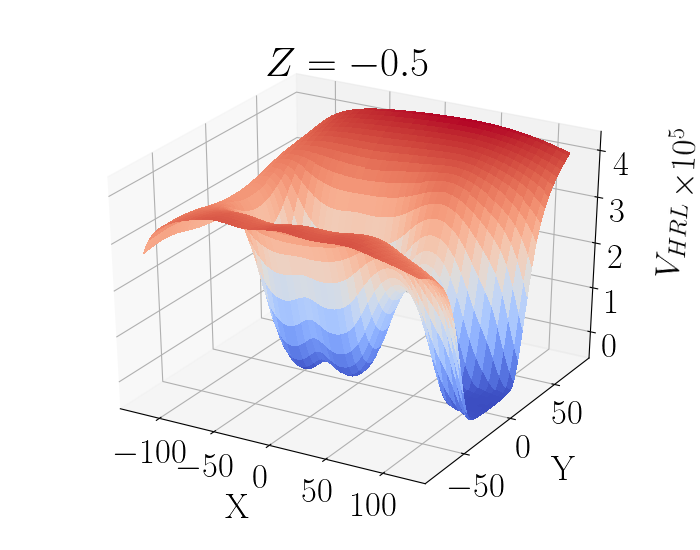

Text(0.5, 0, '$V_{HRL}$')

In [50]:
# X, Y plots
z_plane = -.5
fig = plt.figure()
ax = fig.gca(projection='3d')
X, Y = np.meshgrid(xs, ys)
Z = ephi[:,:,zs == z_plane]
surf = ax.plot_surface(X, Y, Z[:,:,0].T , cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

ax.set_title('$Z =' + np.str(z_plane)+'$')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('$V_{HRL}$')

<IPython.core.display.Javascript object>


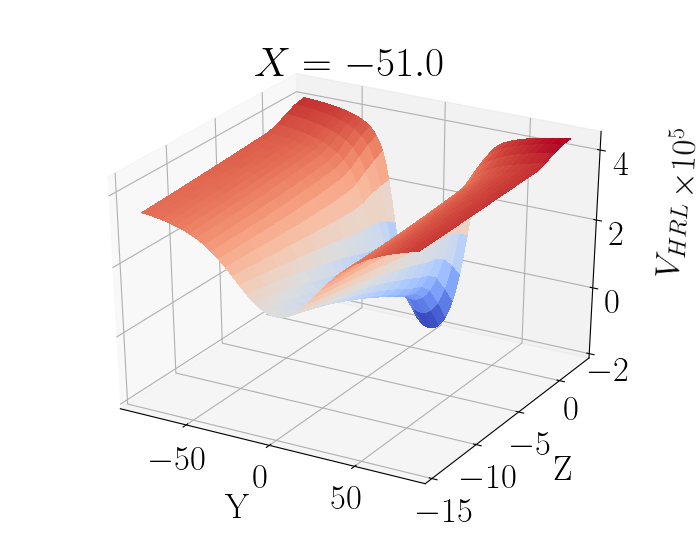

Text(0.5, 0, '$V_{HRL}$  ')

In [7]:
# y, Z plots
x_plane = -51.
fig = plt.figure()
ax = fig.gca(projection='3d')
X, Y = np.meshgrid(ys, zs)
Z = ephi[xs == x_plane,:,:]
surf = ax.plot_surface(X, Y, Z[0,:,:].T , cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# z_label = '$V_{HRL}('+ np.str(y_plane) +')$'
ax.set_title('$X =' + np.str(x_plane)+'$')
ax.set_xlabel('Y')
ax.set_ylabel('Z')
ax.set_zlabel('$V_{HRL}$  ')

In [51]:
np.shape(Z)

(120, 80, 1)

<IPython.core.display.Javascript object>


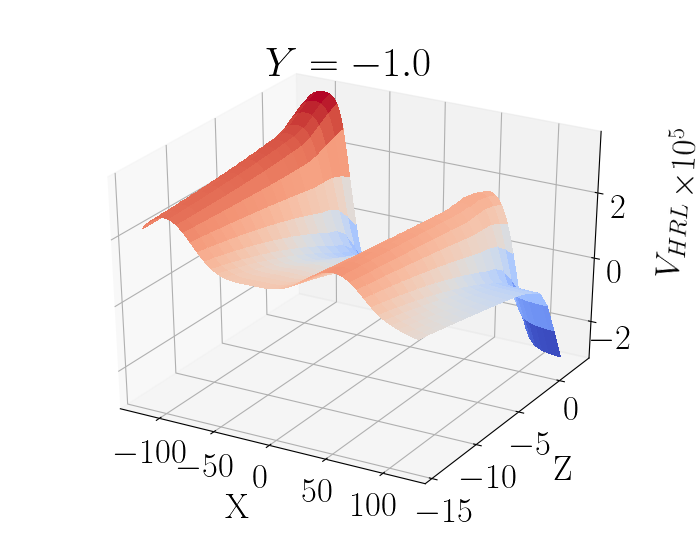

Text(0.5, 0, '$V_{HRL}$  ')

In [52]:
# X, Z plots
y_plane = -1.
fig = plt.figure()
ax = fig.gca(projection='3d')
X, Y = np.meshgrid(xs, zs)
Z = ephi[:,ys == y_plane,:]
surf = ax.plot_surface(X, Y, Z[:,0,:].T , cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# z_label = '$V_{HRL}('+ np.str(y_plane) +')$'
ax.set_title('$Y =' + np.str(y_plane)+'$')
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('$V_{HRL}$  ')

In [9]:
a1 = np.array([1 , 2 , 4])
a2 = np.array([1 , 2 , 4])
V_2d(a1 , a2)

array([ 209.99602887,  839.9841155 , 3359.93646198])

In [59]:
def KineticEnergy(MassVec,path):
    '''Computes kinetic energy of path of an electron path
       inputs: MassVec(3*1-array)
               path(3*N-array)
       return: Energy vector(N-array)
    '''
    return (.5/(4*tau**2))*np.matmul(np.transpose(MassVec),(path[:,2:]-path[:,:-2])**2)



def find_action(path1,path2):
    '''Computes the action given two electron paths
       inputs: Path1 , Path2: 3*N-arrays
       outputs: Action(real)
    '''
    V_interaction = interaction * np.mean(ee(path1[:,1:-1],path2[:,1:-1]))
    s1 = tau*KineticEnergy(m,path1)
    s1 = np.mean(s1) + tau * np.mean(V_field(path1[:,1:-1]))# + V_interaction
    s2 = tau*KineticEnergy(m,path2)
    s2 = np.mean(s2) + tau * np.mean(V_field(path2[:,1:-1]))# + V_interaction
    s = s1 + s2 + 2 * np.log(2 * np.pi * tau / meff) + tau * V_interaction
    return s


   
""" Compares path w/o first element w/ path w/o last element, multiplying 0th*1st, 1st*2nd etc. and summing all sign changes """
def tunnelling_rate(path):
    localmax = 26
    tunnellings = (((path[0][:-1]+localmax) * (path[0][1:]+localmax)) < 0).sum() # +max to shift for potential to change for local max between dots
    rate = tunnellings/len(path)
    return tunnellings, rate


        
def transition_exponent(old_point,new_point):
    return np.dot(new_point - old_point - delta_t * dV_field(old_point), new_point - old_point - delta_t * dV_field(old_point)) / (2 * delta_t)
        
def accept(old_path,new_path):
    old_path = new_path
        
def V_spring(path):
    return np.dot(path[:,time_p] - path[:,time], path[:,time_p] - path[:,time]) / (4*lamda*tau) # different time?
        
def dV_spring(path):
    return (path[:,time_p] - path[:,time] + path[:,time_m] - path[:,time]) / (4*lamda*tau)
        


In [60]:
'''Draft sheet'''
test_Path1 = create_TestPath(1000,.3)
test_Path2 = create_TestPath(1000,.8)
# find_action(test_Path1,test_Path2)
# interaction


import time
start_time = time.time()
for i in range(10000):
    find_action(test_Path1,test_Path2)
print("Value of the action. ----", find_action(test_Path1,test_Path2))
print("--- %s seconds ---" % (time.time() - start_time))

Value of the action. ---- 8.742466189247162
--- 25.6600821018219 seconds ---


In [20]:
N = 20
np.random.uniform(1,N-1,N)

array([ 1.17694801, 18.70497646, 15.55284794,  6.12392773, 10.41799851,
       18.97478497,  9.22154552, 12.59154908, 13.39517905, 15.74226406,
       17.94869564,  5.18558909,  3.08615702, 13.45178623,  5.22840188,
        3.48244563, 16.32210748, 11.53894974,  3.92603541, 18.01030912])

### Experiment with center of mass -like sweeps : 
    1- The implemented algorithm is about a 130 times faster . 
    2- Several implementations need to be taken into account to equiparate it to worm PIMC. The separation of kinetic and potential energy might be crucial for the algorithm to work. This idea is still not considered in this experiment. 
    3- Vectorization and action records have been implemented in the algorithm and are the main actors to explain the increase in efficiency of the algorithm. 
    4- The main idea of the algorithm has changed drastically since the initial implementation, making it difficult to compare it with  the previous implementation. However, previous ideas like spring potentials to force initial convergence might still be implemented. 
    

In [29]:

"""
One sweep consists of trying N times changing a random element in the array path (size of this change depends on h),
each time accepting/refusing according to Metropolis. 
"""



def sweep(path1,path2, So):
    N = len(path1[0])

#     index=np.random.uniform(1,N-1,N) # Order in which path changes are tried. Endpoints (0 and N-1) kept fixed.
#     metropolis_comparison = np.random.uniform(0,1,N)
    
    # Creating 3N random numbers.
    rand_r1 = (h/2)*(np.random.rand(3,N)-.5)
    # Creating 3N random numbers.
    rand_r2 = (h/2)*(np.random.rand(3,N)-.5)
#     return rand_r1, rand_r2
    
    new_path1 = path1 + rand_r1
    new_path2 = path2 + rand_r2
    
    #So = find_action(path1,path2)   #--- not necessary if the action is saved
    Sn = find_action(new_path1,new_path2)
    
    delta_s = Sn -So 
    
#     print(So, Sn , delta_s)
    if delta_s < 0: # always accepting if action lowered
        So = Sn
        print(2, So)
        return new_path1 , new_path2 , So
    elif np.random.rand(1) < np.exp(-(delta_s/hbar)): #otherwise accepte with specific probability.
        So = Sn
        print(1, So)
        return new_path1 , new_path2 , So
        
    else:
        print(0, So)
        return path1 , path2, So
        
    

    

# np.shape(sweep(test_Path1, test_Path2)[0])

start_time = time.time()

N1 = 1000
# 
p1 = .5*generate_path(N1)
# 
p2 = .3*generate_path(N1)
# p1 = create_TestPath(N1,.3)
# p2 = create_TestPath(N1,.1)
So = find_action(p1,p2)

for i in range(10000):
    pp1 , pp2 , newS = sweep(p1 , p2 ,So)
    p1 = pp1
    p2 = pp2
    So = newS
print("--- %s seconds ---" % (time.time() - start_time))

0 27.49977186866581
1 27.928592581263633
1 28.21143624782488
0 28.21143624782488
0 28.21143624782488
1 28.503647876948705
0 28.503647876948705
1 28.700242860745156
0 28.700242860745156
1 28.985897326838117
0 28.985897326838117
1 29.194519801688237
1 29.56681065529972
1 29.86744170488874
0 29.86744170488874
1 30.225713317692232
1 30.57199345457118
1 30.86557782166847
1 31.136837889785024
1 31.463002887776994
0 31.463002887776994
1 31.81300264269191
1 32.011989302194536
0 32.011989302194536
0 32.011989302194536
1 32.2938245813685
0 32.2938245813685
1 32.51108986524136
1 32.81673864822333
1 33.12699712676099
1 33.47153121885055
0 33.47153121885055
0 33.47153121885055
0 33.47153121885055
0 33.47153121885055
1 33.703817532874154
0 33.703817532874154
0 33.703817532874154
1 34.0890118106871
1 34.33488409372854
1 34.73034960172709
1 35.019304409850626
1 35.18612818167099
1 35.30126357792371
1 35.71264105371666
1 36.00665184394129
1 36.2154005503273
1 36.61302667451468
1 37.03937874628351
1 37.

1 142.36266789258133
1 142.7981973037519
1 143.17691589505625
1 143.68385206947872
2 143.37575601223932
0 143.37575601223932
0 143.37575601223932
1 143.60905982622938
0 143.60905982622938
1 143.87147821893464
1 144.00158716230553
0 144.00158716230553
1 144.40757719560887
1 144.68024745771518
2 144.65446689570166
1 145.15367925749425
1 145.49114650788164
1 146.13879074380569
1 146.47310341830953
0 146.47310341830953
0 146.47310341830953
1 146.88385029570367
1 147.14977844679174
1 147.4521464519265
1 147.66414341539783
0 147.66414341539783
0 147.66414341539783
0 147.66414341539783
1 147.89687782930997
2 147.87136803007016
1 148.13466506953532
0 148.13466506953532
1 148.19181953331292
0 148.19181953331292
1 148.80336830364712
1 148.8072309732823
1 148.84717019204487
1 149.28990122374648
0 149.28990122374648
1 149.33075419330854
1 149.666664498932
1 150.0570747250797
1 150.5003182741123
1 150.96352335238356
0 150.96352335238356
1 151.14165340880413
1 151.17942768272837
0 151.17942768272837

0 229.09050936604726
2 229.05506442141927
1 229.52346480555272
1 229.94009674779477
0 229.94009674779477
2 229.5620258814056
0 229.5620258814056
1 229.69234545178577
0 229.69234545178577
1 229.99869462313245
0 229.99869462313245
1 230.09121414112204
1 230.38283348538297
1 230.70856559557845
1 231.27319156976327
1 231.40343152737518
0 231.40343152737518
1 231.47000681291186
0 231.47000681291186
1 231.9319501200902
1 232.07695451581174
0 232.07695451581174
0 232.07695451581174
1 232.42852812108984
0 232.42852812108984
1 232.7336612938284
2 232.66246214508112
2 232.31424796954505
2 232.24868632176654
0 232.24868632176654
1 232.42221705820458
1 232.5657636900578
1 233.1748817294431
1 233.59776472060054
1 233.74212632183952
0 233.74212632183952
0 233.74212632183952
0 233.74212632183952
0 233.74212632183952
1 233.91818010066564
0 233.91818010066564
1 234.05794534217134
0 234.05794534217134
1 234.1897160144305
1 234.83047012803752
1 235.3517431840864
0 235.3517431840864
2 235.19819094762315
0

0 306.41768506715255
0 306.41768506715255
0 306.41768506715255
1 306.816163965148
0 306.816163965148
0 306.816163965148
1 306.8503589231485
0 306.8503589231485
0 306.8503589231485
1 307.25815059278193
0 307.25815059278193
2 307.10915725729984
1 307.27409440833
0 307.27409440833
2 307.20060257401656
0 307.20060257401656
2 306.84637107618437
2 306.7162918402402
1 307.39058083283334
1 307.90995964492987
1 308.2569730806259
1 308.9691876857152
0 308.9691876857152
0 308.9691876857152
1 309.18717441019334
0 309.18717441019334
0 309.18717441019334
0 309.18717441019334
1 309.80059058230984
1 309.9487314250181
1 310.88520071366713
1 311.17982703451236
0 311.17982703451236
1 311.6913329085868
0 311.6913329085868
1 311.82151967569894
2 311.66239041375525
0 311.66239041375525
1 311.7831659062069
1 311.9327469612453
1 311.985153527726
0 311.985153527726
2 311.8338463330671
1 312.84929591531414
0 312.84929591531414
0 312.84929591531414
1 312.9321442266642
1 313.4612436125016
0 313.4612436125016
0 31

0 367.99879568305573
2 367.8390410473876
1 368.158258119836
1 368.81798027723414
2 368.7088996180059
1 368.7193433282817
0 368.7193433282817
1 369.3203144361616
0 369.3203144361616
1 369.793710898597
0 369.793710898597
1 370.5505620440825
2 370.492356654782
1 370.6163821074063
2 370.51482799653166
0 370.51482799653166
1 371.12156512163915
1 371.6946331038033
2 370.7536418665436
2 370.5421275272436
2 370.4720110602007
1 370.67272778990366
0 370.67272778990366
2 370.44883411679024
2 370.11969159322314
0 370.11969159322314
1 370.21892423090156
1 370.23372586276344
1 370.46911148979194
1 371.4671243651148
0 371.4671243651148
0 371.4671243651148
2 371.45421467282245
0 371.45421467282245
0 371.45421467282245
0 371.45421467282245
0 371.45421467282245
1 371.8631389039938
0 371.8631389039938
0 371.8631389039938
0 371.8631389039938
0 371.8631389039938
0 371.8631389039938
2 371.8256757153706
0 371.8256757153706
0 371.8256757153706
0 371.8256757153706
1 372.5642146708009
1 372.5989260102017
0 372.

1 432.5274736665583
1 432.89215714421147
0 432.89215714421147
2 432.85957803893655
0 432.85957803893655
2 432.77128619593356
0 432.77128619593356
1 433.2567081076238
1 433.7065889709019
1 433.94253526099516
0 433.94253526099516
0 433.94253526099516
1 434.3920456119764
1 434.54530641108704
0 434.54530641108704
2 434.27526467838084
1 434.5162243843856
2 434.3037001922337
1 434.6806507251869
0 434.6806507251869
2 434.6043442451581
1 434.8920823646215
2 434.5773622101581
1 434.80126061789014
0 434.80126061789014
1 434.8417461185274
2 434.370311385033
0 434.370311385033
2 434.163267089307
2 434.12480632371086
0 434.12480632371086
0 434.12480632371086
2 434.0730023885198
1 434.1303785072708
2 434.07111474369077
1 434.63149283477924
2 434.53036915747094
1 434.94571451888254
0 434.94571451888254
1 435.16055736592716
0 435.16055736592716
2 434.91553819488354
1 435.34000825550453
1 435.5442036621156
1 435.59571499057057
2 435.43635036598806
2 435.303264281883
2 434.8771659635001
0 434.8771659635

2 487.6291925810624
1 487.74553150809015
0 487.74553150809015
1 488.29113302006334
1 488.6178279903351
1 488.9259601041434
1 489.2918288044793
0 489.2918288044793
1 489.5760837240354
2 489.2218597038938
1 489.3624807407385
1 489.3759052187003
0 489.3759052187003
1 489.6306979276192
2 489.61177793295263
2 489.11917164402695
1 489.3728636725458
0 489.3728636725458
0 489.3728636725458
2 489.01000252159156
0 489.01000252159156
0 489.01000252159156
1 489.08153368216006
2 489.06089541270677
1 490.1565006286813
0 490.1565006286813
1 490.2266931292732
2 489.8181029542812
2 489.4601887479932
0 489.4601887479932
1 489.75792942792447
1 490.160072922606
2 489.7945294406984
2 489.75317290026913
0 489.75317290026913
1 489.9563061447944
1 490.0145641726249
0 490.0145641726249
1 490.3506783462389
0 490.3506783462389
2 490.1223353204094
2 490.0464150421719
0 490.0464150421719
0 490.0464150421719
1 490.3758009895227
0 490.3758009895227
0 490.3758009895227
1 490.46679051629224
1 490.598455666999
2 490.11

0 530.1722589415917
2 529.7991676251687
1 529.9458048462948
0 529.9458048462948
2 529.5829523929906
2 529.5536903510289
1 529.558563412183
1 529.7731957753163
2 529.241220024021
1 529.3851931560591
0 529.3851931560591
1 530.017865407847
2 529.8862006606668
0 529.8862006606668
2 529.7895301576382
1 529.8248268279945
0 529.8248268279945
0 529.8248268279945
0 529.8248268279945
2 529.6632157167656
0 529.6632157167656
0 529.6632157167656
1 530.3998429855121
2 530.0419531349901
2 530.0006189078844
0 530.0006189078844
0 530.0006189078844
1 530.080212328857
0 530.080212328857
1 530.4623183656164
1 531.2911278411568
0 531.2911278411568
0 531.2911278411568
0 531.2911278411568
1 531.9924172632685
1 532.508018340305
2 532.317531707763
0 532.317531707763
2 532.2308257017822
0 532.2308257017822
1 532.5028423966479
1 532.5906523094042
1 532.7149674229131
2 532.240239204076
2 531.9643899550185
0 531.9643899550185
1 532.6519210024597
0 532.6519210024597
2 532.4875104109251
0 532.4875104109251
1 532.584

1 561.1150409336816
1 561.4192185697224
2 560.627062717135
0 560.627062717135
2 560.3249150512221
0 560.3249150512221
0 560.3249150512221
1 561.7241032551532
0 561.7241032551532
1 561.7441178101768
0 561.7441178101768
1 561.7799670604626
1 561.9205155518008
2 561.7277724717346
1 562.0039731340366
0 562.0039731340366
0 562.0039731340366
1 562.3582381468358
0 562.3582381468358
0 562.3582381468358
0 562.3582381468358
1 562.3658238184262
2 562.2115627084304
1 562.5497027771808
2 562.29533694823
1 562.7528711567719
2 562.6550847624027
0 562.6550847624027
0 562.6550847624027
1 562.6914493463122
1 563.1785904020406
0 563.1785904020406
0 563.1785904020406
0 563.1785904020406
1 563.5225445346081
2 563.2188156572169
0 563.2188156572169
0 563.2188156572169
0 563.2188156572169
2 563.1674394634222
0 563.1674394634222
1 563.301849471845
2 563.0953803986694
0 563.0953803986694
1 563.318516366066
2 562.8199704286485
1 563.3771332599051
1 563.527095525773
2 563.0333306745051
0 563.0333306745051
1 563.6

1 588.7271354018518
2 588.4577479798459
2 588.260226155536
1 588.7225049553432
1 589.1606896236598
1 589.3140158359887
2 588.9305267008314
2 588.856892355451
2 588.441460752952
2 588.2136060495022
1 588.2785133254664
0 588.2785133254664
2 587.3264248552342
2 587.1887205705788
1 588.0939546697055
0 588.0939546697055
0 588.0939546697055
0 588.0939546697055
2 587.2343824033834
2 587.2113177485713
2 587.0547326629022
0 587.0547326629022
0 587.0547326629022
1 587.0695181554039
1 587.2185567181739
0 587.2185567181739
1 587.3392927206769
1 588.0540864490783
1 588.8780749991598
0 588.8780749991598
0 588.8780749991598
0 588.8780749991598
1 588.9834755017175
0 588.9834755017175
2 588.9070313569987
1 589.1733274228583
1 589.4178843313636
1 590.1492151585572
0 590.1492151585572
0 590.1492151585572
0 590.1492151585572
2 589.7946360048253
0 589.7946360048253
0 589.7946360048253
0 589.7946360048253
2 589.6349467522025
1 590.5773083848078
1 590.8247984389085
1 591.6479024797692
1 591.8385913226927
2 5

0 611.1014041018271
1 611.585906305581
1 612.0985360432078
1 612.4413029996188
0 612.4413029996188
2 612.0531188918601
0 612.0531188918601
0 612.0531188918601
1 612.0824505792161
2 611.2642900309799
1 611.6802456116314
2 611.3979392961083
0 611.3979392961083
2 611.2288159437456
0 611.2288159437456
0 611.2288159437456
2 611.1493450688328
0 611.1493450688328
1 611.2736233934362
1 612.2157146419743
1 612.3651814507347
0 612.3651814507347
0 612.3651814507347
2 612.2988277557603
0 612.2988277557603
2 611.813832911266
1 612.4895748801133
2 612.458868111329
0 612.458868111329
0 612.458868111329
1 612.7360695446991
1 612.9011096596448
1 612.9521170944436
1 613.2490693624162
0 613.2490693624162
1 613.7024164243423
1 613.7963785469723
2 613.1089187596981
1 613.4900694907693
1 613.5543505271145
2 613.5184777090161
2 613.0937027696884
0 613.0937027696884
2 612.9804655875095
1 613.1406864965218
0 613.1406864965218
1 613.2358445628706
1 613.8173740495422
1 614.7724918352495
1 615.1870722915983
0 615

2 638.2548476823429
0 638.2548476823429
0 638.2548476823429
1 638.8327913599162
2 638.2869153240554
0 638.2869153240554
2 638.2061953150808
0 638.2061953150808
0 638.2061953150808
1 638.4743032893188
1 639.2428445293367
2 639.021736189738
1 639.230756963569
1 639.4571609387126
0 639.4571609387126
2 639.2099548562838
2 639.0437910149143
0 639.0437910149143
1 639.2369679011142
0 639.2369679011142
0 639.2369679011142
1 639.285959403143
0 639.285959403143
0 639.285959403143
0 639.285959403143
0 639.285959403143
2 639.0969282940272
1 640.1154846823318
0 640.1154846823318
0 640.1154846823318
1 640.5299549321834
1 640.8773125885193
2 640.5505214687925
1 640.6471603276322
2 640.3837606865825
0 640.3837606865825
0 640.3837606865825
1 640.5420913956975
2 640.3015206530542
1 641.0713457987147
0 641.0713457987147
1 641.1511715969096
1 642.1293367779797
0 642.1293367779797
1 642.7374883509505
2 642.3822805884597
1 642.8840081891719
1 643.2785109259445
1 643.8937277198207
0 643.8937277198207
0 643.8

1 670.7065050979165
1 671.1770510023842
2 670.956249446582
1 671.018854490462
0 671.018854490462
0 671.018854490462
0 671.018854490462
1 671.2690962820997
1 671.5551419114968
1 671.8338425528879
2 671.7785866645561
2 671.6936887632666
2 671.5989898331096
1 671.7072473599139
1 672.2855564432633
1 673.1237290255332
0 673.1237290255332
1 673.8120853301299
0 673.8120853301299
1 674.2784845341611
0 674.2784845341611
0 674.2784845341611
0 674.2784845341611
2 674.0554480384835
1 674.2244187317136
2 673.7242123982278
2 673.6360700546882
1 674.2596954623289
1 674.5414792793775
0 674.5414792793775
1 674.7911460500658
0 674.7911460500658
1 675.4958608092334
2 675.4067800717993
1 675.5082712474134
2 675.4246428495765
2 675.1883437105274
0 675.1883437105274
2 674.9018871853923
2 674.2762915691552
1 674.5319394862918
0 674.5319394862918
1 675.0408316131326
0 675.0408316131326
0 675.0408316131326
1 675.379300043912
1 676.4654408899122
0 676.4654408899122
0 676.4654408899122
1 676.9898767892066
1 677.

0 717.7844909989486
0 717.7844909989486
0 717.7844909989486
0 717.7844909989486
0 717.7844909989486
0 717.7844909989486
1 717.8205413515204
1 718.047891699102
1 718.7060138281848
0 718.7060138281848
0 718.7060138281848
0 718.7060138281848
1 719.1086487974706
1 719.3146154061521
0 719.3146154061521
0 719.3146154061521
1 719.3473308791048
2 718.6764668470954
1 719.3432612682642
2 719.2767595516149
2 719.1747280479965
0 719.1747280479965
2 719.0360741022483
1 719.1973483478938
0 719.1973483478938
1 719.5257034206569
2 719.2911135029065
2 718.8059856031186
1 719.2148046678833
2 718.7674423321808
1 719.0318854292891
0 719.0318854292891
2 718.7263917383342
1 718.9495403659774
2 718.7272670380758
2 718.438092415092
2 718.2849949806223
2 718.0224193096054
0 718.0224193096054
0 718.0224193096054
2 717.9590104605693
0 717.9590104605693
0 717.9590104605693
1 718.5247785550519
1 719.2021554037005
0 719.2021554037005
1 719.7271452234457
2 719.4193707101841
1 720.1097378822769
0 720.1097378822769
0 

0 749.5606803965288
2 749.2313144066192
1 750.2648733632551
0 750.2648733632551
1 750.3318208251094
0 750.3318208251094
0 750.3318208251094
0 750.3318208251094
2 750.2016960352807
1 750.4635628999722
1 750.8726464762253
0 750.8726464762253
2 750.688223703572
1 751.2526539186277
0 751.2526539186277
1 751.5040610941926
0 751.5040610941926
0 751.5040610941926
1 751.5834790393269
2 751.3632165020188
2 751.1569240725427
2 751.0559648244983
1 751.1534321567476
2 750.9303995053959
1 751.3257232867892
2 750.8099814720961
2 750.6959354848253
0 750.6959354848253
0 750.6959354848253
1 750.8500952074488
1 751.4785259576319
0 751.4785259576319
2 751.2937767800108
0 751.2937767800108
2 750.9984941944779
1 751.3767517918012
1 751.501726207081
0 751.501726207081
0 751.501726207081
1 752.1064425416307
0 752.1064425416307
1 752.6872449134855
1 753.7585781763372
2 753.4628334448619
1 753.5895239652069
2 753.5013083481034
1 753.8702087521214
0 753.8702087521214
1 754.6251841851974
1 755.180160611223
1 755

0 779.7175343451687
0 779.7175343451687
2 779.1031544088629
0 779.1031544088629
0 779.1031544088629
0 779.1031544088629
0 779.1031544088629
0 779.1031544088629
1 779.2577670786757
2 779.1461713552135
0 779.1461713552135
2 779.0191137836497
1 779.2377441473881
2 778.9428307264823
1 779.8506009104146
0 779.8506009104146
2 779.5250731239421
2 779.1593925545676
1 779.2569140247234
1 779.3670186811677
0 779.3670186811677
1 779.8591145396678
0 779.8591145396678
1 780.0657739519576
2 779.610153024319
0 779.610153024319
1 779.7557740554233
0 779.7557740554233
1 780.8836515868026
2 780.3981753305562
1 780.5471141451214
2 779.9124080163747
1 780.3376680533414
2 780.2982847853243
0 780.2982847853243
1 780.5972839237305
0 780.5972839237305
0 780.5972839237305
0 780.5972839237305
1 780.755850409478
0 780.755850409478
1 781.1771135996102
1 781.8004207143921
0 781.8004207143921
0 781.8004207143921
2 781.6507202961409
0 781.6507202961409
2 781.56962073022
1 782.2969999027704
0 782.2969999027704
2 782.

1 795.638096442118
0 795.638096442118
0 795.638096442118
2 795.4079490850986
1 795.7098825726576
2 795.4167225104547
0 795.4167225104547
0 795.4167225104547
1 795.9585649757674
2 795.9390360190289
0 795.9390360190289
0 795.9390360190289
1 796.6576812148106
0 796.6576812148106
2 796.5004527281591
0 796.5004527281591
2 796.296123997039
1 796.4332679574617
1 797.0607667898447
0 797.0607667898447
0 797.0607667898447
1 797.2629092131331
2 797.2050900046918
2 797.0177077195453
1 797.537325331001
1 797.930605469129
0 797.930605469129
0 797.930605469129
0 797.930605469129
0 797.930605469129
0 797.930605469129
0 797.930605469129
1 798.6428895896142
1 798.8087016395559
0 798.8087016395559
1 799.0479843589629
0 799.0479843589629
0 799.0479843589629
0 799.0479843589629
1 799.27558371185
0 799.27558371185
0 799.27558371185
1 799.7356652509666
1 799.934953177968
0 799.934953177968
1 800.0479344346545
1 800.5438458155525
0 800.5438458155525
0 800.5438458155525
0 800.5438458155525
0 800.5438458155525


1 837.7097126877218
2 837.441846054698
2 837.0628652001591
1 837.1808272122247
2 836.7493868270584
1 837.4325416992688
0 837.4325416992688
0 837.4325416992688
0 837.4325416992688
1 837.5675980311869
2 837.0888539070277
2 836.9670367177544
2 836.6045221530492
1 836.8845241359111
2 836.6495102549534
1 836.6630241947971
0 836.6630241947971
0 836.6630241947971
0 836.6630241947971
0 836.6630241947971
1 836.9015163424662
1 837.5383104160514
0 837.5383104160514
1 838.1044392795343
1 838.3513340513073
2 837.9260826238711
2 837.653964397459
1 837.7894065646585
2 837.2700651539046
0 837.2700651539046
0 837.2700651539046
0 837.2700651539046
0 837.2700651539046
2 836.9961692944837
1 837.1113963840515
0 837.1113963840515
2 837.0805420966045
0 837.0805420966045
0 837.0805420966045
0 837.0805420966045
1 837.7672953625769
0 837.7672953625769
2 837.3934644356411
1 837.9537621349195
0 837.9537621349195
1 838.7046304291318
1 839.0231076370401
1 839.0654122910504
0 839.0654122910504
2 838.2683418066954
2 

In [ ]:



"""
One sweep consists of trying N times changing a random element in the array path (size of this change depends on h),
each time accepting/refusing according to Metropolis. 
"""

def sweep(path1,path2):
    N = len(path1[0])

    index=np.random.uniform(1,N-1,N) # Order in which path changes are tried. Endpoints (0 and N-1) kept fixed.
    metropolis_comparison = np.random.uniform(0,1,N)
    
    # Creating 3N random numbers.
    rand_x_1=np.random.uniform(0,1,N) 
    rand_y_1=np.random.uniform(0,1,N)
    rand_z_1=np.random.uniform(0,1,N)
    # Creating 3N random numbers.
    rand_x_2=np.random.uniform(0,1,N) 
    rand_y_2=np.random.uniform(0,1,N)
    rand_z_2=np.random.uniform(0,1,N)
    
    for i in range(0,N):
        time=int(index[i])
        time_m=int((time-1))
        time_p=int((time+1))
        
        
        '''
        DON'T NEED TO COMPUTE THE OLD ACTION, SAVE OLD ACTIONS IN A VECTOR AND MODIFIFY THE CHANGES AFER EACH COMPUTATION
        '''
                
        """
        Calculating change in action due to replacing path[time] by x_new. Different potentials considered.
        """
        
        
        '''The area between horizontal lines can be ommited simply by saving the old enegies &/or actions in an array'''
       #------------------------------------------------------------------------------------------
        #Kinetic energy 
        so1_px = (path1[0,time_p]-path1[0,time])**2
        so1_py = (path1[1,time_p]-path1[1,time])**2
        so1_pz = (path1[2,time_p]-path1[2,time])**2
        so1_mx = (path1[0,time]-path1[0,time_m])**2
        so1_my = (path1[1,time]-path1[1,time_m])**2
        so1_mz = (path1[2,time]-path1[2,time_m])**2
        
        so2_px = (path2[0,time_p]-path2[0,time])**2
        so2_py = (path2[1,time_p]-path2[1,time])**2
        so2_pz = (path2[2,time_p]-path2[2,time])**2
        so2_mx = (path2[0,time]-path2[0,time_m])**2
        so2_my = (path2[1,time]-path2[1,time_m])**2
        so2_mz = (path2[2,time]-path2[2,time_m])**2
        
        T_old1x = 0.5 * mx * (so1_px + so1_mx) / tau**2
        T_old1y = 0.5 * my * (so1_py + so1_my) / tau**2
        T_old1z = 0.5 * mz * (so1_pz + so1_mz) / tau**2
        T_old2x = 0.5 * mx * (so2_px + so2_mx) / tau**2
        T_old2y = 0.5 * my * (so2_py + so2_my) / tau**2
        T_old2z = 0.5 * mz * (so2_pz + so2_mz) / tau**2
        T_old1 = T_old1x + T_old1y + T_old1z
        T_old2 = T_old2x + T_old2y + T_old2z
        T_old = T_old1 + T_old2 # There would be a cleaner way to calculate this kinetic energy with dot products etc

        
        #Computes Old spring potential 
        V_spring_old1 = V_spring(path1)
        V_spring_old2 = V_spring(path2) 
        dV_spring_old1 = dV_spring(path1)
        dV_spring_old2 = dV_spring(path2)
        
        #Computes Old Vfield
        V_field_old1 = V_field(path1[:,time])
        V_field_old2 = V_field(path2[:,time])
        dV_field_old1 = dV_field(path1[:,time])
        dV_field_old2 = dV_field(path2[:,time])
        #Computes Old interaction
        V_interaction_old = interaction * ee(path1[:,time],path2[:,time])
        
        #Adds all Old components of the energy
        V_eff_old1 = V_field_old1 + V_spring_old1
        V_eff_old2 = V_field_old2 + V_spring_old2
        V_eff_old = V_eff_old1 + V_eff_old2 + V_interaction_old # For biased step
         
        dV_eff_old1 = dV_spring_old1 - 0.5 * tau * dV_field_old1
        dV_eff_old2 = dV_spring_old2 - 0.5 * tau * dV_field_old2
        
        E_old1 = T_old1 + V_field_old1 + V_interaction_old
        E_old2 = T_old2 + V_field_old2 + V_interaction_old
        E_old = E_old1 + E_old2 - V_interaction_old
        
        #Computes the old action 
        s_old1 = tau * E_old1
        s_old2 = tau * E_old2
        s_old = tau * E_old
        
        #------------------------------------------------------------------------------------------
        
        
        
        #Driven delta
        delta_r1 = delta_t * dV_eff_old1
        delta_r2 = delta_t * dV_eff_old2
        
        #Creates new positions using driven force and random shift
        x_new_1 = path1[0,time] + bias * delta_r1[0] + h * (rand_x_1[i]-0.5)
        y_new_1 = path1[1,time] + bias * delta_r1[1] + h * (rand_y_1[i]-0.5)
        z_new_1 = path1[2,time] + bias * delta_r1[2] + h * (rand_z_1[i]-0.5)
        
        x_new_2 = path2[0,time] + bias * delta_r2[0] + h * (rand_x_2[i]-0.5)
        y_new_2 = path2[1,time] + bias * delta_r2[1] + h * (rand_y_2[i]-0.5)
        z_new_2 = path2[2,time] + bias * delta_r2[2] + h * (rand_z_2[i]-0.5)
        
        r_new_1 = [x_new_1,y_new_1,z_new_1]
        r_new_2 = [x_new_2,y_new_2,z_new_2]
        
        #Kinetic energy of new position 
        sn1_px = (path1[0,time_p]-r_new_1[0])**2
        sn1_py = (path1[1,time_p]-r_new_1[1])**2
        sn1_pz = (path1[2,time_p]-r_new_1[2])**2
        sn1_mx = (r_new_1[0]-path1[0,time_m])**2
        sn1_my = (r_new_1[1]-path1[1,time_m])**2
        sn1_mz = (r_new_1[2]-path1[2,time_m])**2
        
        sn2_px = (path2[0,time_p]-r_new_2[0])**2
        sn2_py = (path2[1,time_p]-r_new_2[1])**2
        sn2_pz = (path2[2,time_p]-r_new_2[2])**2
        sn2_mx = (r_new_2[0]-path2[0,time_m])**2
        sn2_my = (r_new_2[1]-path2[1,time_m])**2
        sn2_mz = (r_new_2[2]-path2[2,time_m])**2
        
        T_new1x = 0.5 * mx * (sn1_px + sn1_mx) / tau**2
        T_new1y = 0.5 * my * (sn1_py + sn1_my) / tau**2
        T_new1z = 0.5 * mz * (sn1_pz + sn1_mz) / tau**2
        T_new2x = 0.5 * mx * (sn2_px + sn2_mx) / tau**2
        T_new2y = 0.5 * my * (sn2_py + sn2_my) / tau**2
        T_new2z = 0.5 * mz * (sn2_pz + sn2_mz) / tau**2
        T_new1 = T_new1x + T_new1y + T_new1z
        T_new2 = T_new2x + T_new2y + T_new2z
        T_new = T_new1 + T_new2
        
        V_field_new1 = V_field(r_new_1)
        V_field_new2 = V_field(r_new_2)
        V_field_new = V_field_new1 + V_field_new2
       
        V_interaction_new = interaction * ee(r_new_1,r_new_2)

#         New energy, sum of cinetic , V_field and C_interaction
        E_new1 = T_new1 + V_field_new1 + V_interaction_new
        E_new2 = T_new2 + V_field_new2 + V_interaction_new
        E_new = E_new1 + E_new2 - V_interaction_new
        
#         New action
        s_new1 = tau * E_new1
        s_new2 = tau * E_new2
        s_new = tau * E_new
        
#         Changes in action 
        delta_s1 = s_new1 - s_old1
        delta_s2 = s_new2 - s_old2
        delta_s = s_new - s_old

        if bias == 0:
            if interaction == 1:
                if delta_s < 0: # always accepting if action lowered
                    accept(path1[:,time],r_new_1)
                    accept(path2[:,time],r_new_2)
                elif metropolis_comparison[i]<np.exp(-(delta_s/hbar)): #otherwise accepte with specific probability.
                    accept(path1[:,time],r_new_1)
                    accept(path2[:,time],r_new_2)
            else:
                if delta_s1 < 0: # always accepting if action lowered
                    accept(path1[:,time],r_new_1)
                elif metropolis_comparison[i]<np.exp(-(delta_s1/hbar)): #otherwise accepte with specific probability.
                    accept(path1[:,time],r_new_1)
                if delta_s2 < 0: # always accepting if action lowered
                    accept(path2[:,time],r_new_2)
                elif metropolis_comparison[i]<np.exp(-(delta_s2/hbar)): #otherwise accepte with specific probability.
                    accept(path2[:,time],r_new_2)
        else:
            mu1 = transition_exponent(r_new_1,path1[:,time])
            mu2 = transition_exponent(r_new_2,path2[:,time])
            nu1 = transition_exponent(path1[:,time],r_new_1)
            nu2 = transition_exponent(path2[:,time],r_new_2)
            if nu1 - mu1 + E_old1 - E_new1 > 0: # avoides exponential calculation
                accept(path1[:,time],r_new_1)
            elif metropolis_comparison[i] < np.exp(nu1 - mu1 + E_old1 - E_new1):
                accept(path1[:,time],r_new_1)
            if nu2 - mu2 + E_old2 - E_new2 > 0: # avoides exponential calculation
                accept(path2[:,time],r_new_2)
            elif metropolis_comparison[i] < np.exp(nu2 - mu2 + E_old2 - E_new2):
                accept(path2[:,time],r_new_2)

# %%
                
"""
Returns actions for a crossing or staying system for different N
Might need to fix these, changed them slightly to run on NCI
"""

def perform_pederson(path1,path2): # simply updates paths
    for j in range(num_path):
        sweep(path1,path2)

N_list = np.logspace(1,3,10).astype(int) # N's from 10^1 to 10^3, 10 elements
#print(N_list)

crossing_action_list = [0] * len(N_list)
staying_action_list = [0] * len(N_list)

def find_crossing_actions(N):
    path1crossing = generate_path(N)
    path2crossing = generate_path(N)
    crossing(path1crossing,path2crossing)
    perform_pederson(path1crossing,path2crossing)
    return(N,find_action(path1crossing,path2crossing))

def find_staying_actions(N):
    path1staying = generate_path(N)
    path2staying = generate_path(N)
    staying(path1staying,path2staying)
    perform_pederson(path1staying,path2staying)
    return(N,find_action(path1staying,path2staying))

def find_pederson_actions(N):
    return (find_crossing_actions(N)[1], find_staying_actions(N)[1])

def pederson():
    for i in range(len(N_list)):
        crossing_action_list[i] = find_crossing_actions(N_list[i])[1]
        staying_action_list[i] = find_staying_actions(N_list[i])[1]
        
#pederson()

# %%
        
action_ratio_list = np.divide(crossing_action_list,staying_action_list)

def exchange_coupling():
    slope = linregress(N_list[-int(len(N_list)/4):],action_ratio_list[-int(len(N_list)/4):])[0]
    J = slope / tau
    print('J = ',J,'(ueV)')
    print('J = ',J/hbar,'(nHz)')
    return J
#exchange_coupling()

# %%

plt.plot(N_list,np.log(action_ratio_list),'.-')
plt.xlabel('N')
plt.ylabel('$log(S_X/S_{||})$')
plt.show()


